## The estimated effect/turnover due to store cannibalisation

**This paper attempts to find the cannibalisation effect Lidl stores have had on each other over the years. 
It will look at stores that have had no new stores opening nearby for six months prior and after the intervention and will compare it to stores that have remained without new stores nearby throughout.**

## Variable Description
- **store_number**: Unique ID of every Lidl Store
- **store_desc**: store address
- **date_open**: the date on which the store opened
- **City**: city the store opened in
- **Street**: address of the store
- **CenterX_x**: longitude
- **CenterY_y**: latitude
- **year**: extracted the year on which the store opened
- **month**: extracted the month on which the store opened
- **Distance**: how far the store if from the competitor store
- **store_comp**: unique ID of competitor store
- **city_comp**: city competitor store opened in
- **year_comp**: year in which competitor store opened

In [1]:
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt

In [2]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv ("store_meta.csv", sep=",")
df1 = pd.read_csv ("Open_stores_reach_in_500m.csv", sep=";")
df2 = pd.read_csv ("Open_stores_reach_in_1000m.csv", sep=";")

In [4]:
df1 = df1.rename(columns={'STORENR':'store_number'})
df2 = df2.rename(columns={'STORENR':'store_number'})

In [5]:
df_final = pd.merge(df,df1[['store_number','CenterX','CenterY']],on='store_number', how='left')
df_final=pd.merge(df_final,df2[['store_number','CenterX','CenterY']],on='store_number', how='left')
df_final=df_final[['store_number', 'store_desc', "date_open", "city", "street", "CenterX_x", "CenterY_x"]]
df_final = df_final.dropna(how='any',axis=0)

In [6]:
df_final["date_open"] = pd.to_datetime(df_final["date_open"])


In [7]:
df_final['year'] = pd.DatetimeIndex(df_final['date_open']).year
df_final['month'] = pd.DatetimeIndex(df_final['date_open']).month

In [8]:
df_final

,store_number,store_desc,date_open,city,street,CenterX_x,CenterY_x,year,month
0,350,Budakeszi,2022-02-08,Budakeszi,Kert utca 27-29,"18,9219","47,503278",2022,2
1,359,Bp. XV. Madách u.,2021-11-23,Budapest,Madách u. 72.,"19,138458","47,537053",2021,11
2,362,Aszód,2021-04-11,Aszód,Pesti út 14-16,"19,473387","47,651075",2021,4
3,365,"Szeged, Vásárhelyi Pál út",2021-04-11,Szeged,Vásárhelyi Pál út 7,"20,128316","46,261076",2021,4
4,316,Bp. II. Csalogány u.,2021-03-01,Budapest,Csalogány u. 43.,"19,031565","47,508128",2021,3
...,...,...,...,...,...,...,...,...,...
187,128,Mór,2004-11-18,Mór,Fő 81.,"18,189333","47,375802",2004,11
188,131,Kisvárda,2004-11-18,Kisvárda,Attila 2/a,"22,075787","48,210395",2004,11
189,133,Békéscsaba,2004-11-18,Békéscsaba,Corvin 29-33.,"21,10628","46,670994",2004,11
190,141,Barcs,2004-11-18,Barcs,Erkel F. 2.,"17,466666","45,962336",2004,11


## Number of stores opening each year

In [9]:
df = pd.DataFrame(df_final.groupby('year').count().reset_index(),columns=['year','store_number'])

In [10]:
df=pd.DataFrame(df_final['year'].value_counts().reset_index())

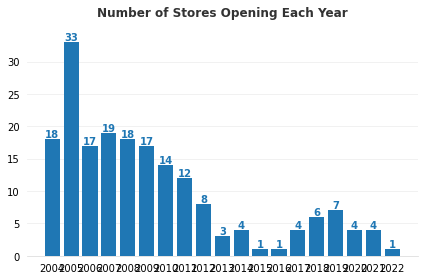

In [11]:
plt.rcParams['figure.figsize'] = (15, 7)

fig, ax = plt.subplots()

bars = ax.bar(
    x=df['index'],
    height=df['year'],
    tick_label=df["index"]
)

fig.tight_layout()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

bar_color = bars[0].get_facecolor()

for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

ax.set_title('Number of Stores Opening Each Year', pad=15, color='#333333', weight='bold')



fig.tight_layout()

**I observed the number of stores opening over the years. After 2011, the number of stores opening significantly decreases meaning potentionally lesser new stores opening hence reducing the sample size. I decided to remove the years after 2011.**

## Calculating Distance between stores established till 2011

In [12]:
df_final_copy = df_final.copy()

In [13]:
df_2011 = df_final_copy[(df_final_copy.year<=2011)]
df_all= df_2011.copy()

In [14]:
df_all["CenterX_x"] = df_all["CenterX_x"].str.replace(',', '.').astype(float)

In [15]:
df_all["CenterY_x"] = df_all["CenterY_x"].str.replace(',', '.').astype(float)

In [16]:
## Calculating distance within all stores uptill 2009

In [17]:
z=[]
s=[]
c=[]
o=[]
for x, y in zip(df_all.CenterX_x, df_all.CenterY_x):
    coords_1=(x,y)
    l = []
    sn=[]
    ci=[]
    od=[]
    for a,b, store_num,cit,open_d in zip(df_all.CenterX_x, df_all.CenterY_x,df_all.store_number, df_all.city,df_all.date_open):
        coords_2=(a,b)
        km = geopy.distance.geodesic(coords_1, coords_2).km
        l.append(km)
        snn= store_num
        sn.append(snn)
        city= cit
        ci.append(city) 
        odd=open_d
        od.append(odd)
    z.append(l)
    s.append(sn)
    c.append(ci)
    o.append(od)


In [18]:
df_all["distance"] = z
df_all["store_comp"] = s
df_all["city_comp"] = c
df_all["open_comp"] = o

In [19]:
df_all = df_all.explode(['distance','store_comp', 'city_comp', "open_comp"])
df_all = df_all[['store_number', "date_open", "city","year", "distance","store_comp","city_comp","open_comp"]]
df_all["open_comp"] = pd.to_datetime(df_all["open_comp"])
df_all['year_comp'] = pd.DatetimeIndex(df_all['open_comp']).year
df_all = df_all.reset_index()
df_all.drop(df_all.index[df_all['distance'] == 0], inplace = True)

In [20]:
df_all['distance'] = df_all['distance'].astype(int)

### Stores sorted by the distance within eachother 

In [21]:
df_all.sort_values("distance")

,index,store_number,date_open,city,year,distance,store_comp,city_comp,open_comp,year_comp
14800,144,177,2005-12-15,Budapest,2005,1,285,Budapest,2011-12-15,2011
19189,173,120,2005-01-27,Szolnok,2005,1,106,Szolnok,2005-12-15,2005
4472,74,221,2009-07-02,Győr,2009,1,200,Győr,2009-05-28,2009
7906,97,235,2008-05-08,Budapest,2008,1,232,Budapest,2007-12-13,2007
14485,141,106,2005-12-15,Szolnok,2005,1,120,Szolnok,2005-01-27,2005
...,...,...,...,...,...,...,...,...,...,...
19680,176,143,2004-12-02,Szombathely,2004,611,131,Kisvárda,2004-11-18,2004
21415,188,131,2004-11-18,Kisvárda,2004,612,139,Szombathely,2005-12-01,2005
15388,147,139,2005-12-01,Szombathely,2005,612,131,Kisvárda,2004-11-18,2004
14204,139,182,2006-02-02,Körmend,2006,619,131,Kisvárda,2004-11-18,2004


In [22]:
df_all.describe()

,index,store_number,year,distance,year_comp
count,21756.000000,21756.000000,21756.000000,21756.000000,21756.000000
mean,117.500000,185.972973,2007.033784,192.325519,2007.033784
std,42.723927,54.182740,2.197763,115.747947,2.197763
min,44.000000,101.000000,2004.000000,1.000000,2004.000000
25%,80.750000,139.750000,2005.000000,105.000000,2005.000000
50%,117.500000,182.500000,2007.000000,177.000000,2007.000000
75%,154.250000,224.500000,2009.000000,261.000000,2009.000000
max,191.000000,306.000000,2011.000000,619.000000,2011.000000


**It was observed that 75% percentage points of the total stores had already opened till 2009. Looking at the dataframe sorted by distance, I decided to move forward with keeping 10km as a baseline for close proximity.**

Average distance between two lidl stores spread in Hungary is 192 km. I decided to keep 10 km as a baseline for close proximity. 


# Finding Stores in Close Proximiy that is within 10km 

**I decided to test how over the years, from 2008-2011, opening new stores every year led to previous stores as well the new stores coming to a 10 km proximity with each other. I wanted to see for example what was the increase due to close proximity in number of stores opened in 2008 - 2010 when new stores opened in 2011. I continued this till comparison between 2008 and 2009**.

In [23]:
df_all[(df_all.distance<11)].count()

index           368
store_number    368
date_open       368
city            368
year            368
distance        368
store_comp      368
city_comp       368
open_comp       368
year_comp       368
dtype: int64

### 2011

In [24]:
test = pd.DataFrame(df_all[(df_all.distance<11)][['year_comp','store_number']].value_counts().sort_index())

In [25]:
test.groupby("year_comp").count() #Table1

,0
year_comp,
2004,12
2005,36
2006,24
2007,33
2008,32
2009,28
2010,26
2011,25


**17 stores more stores from 2004-2010 came in close proximity due to new stores opening in 2011.**

To calculate the difference I used the table below that is Table2 and compared it to Table1. For example, stores that had opened in 2004 have had an increase in 2 more instances of exisiting stores now being in close proximity. 

### 2010

In [26]:
test = pd.DataFrame(df_all[(df_all.distance<11) & (df_all.year<2011) & (df_all.year_comp<2011)][['year_comp','store_number']].value_counts().sort_index())
test.groupby("year_comp").count() #Table2

,0
year_comp,
2004,10
2005,33
2006,21
2007,31
2008,29
2009,26
2010,24


**19 more stores from 2004-2009 came to close proximity due to new stores opening in 2010.**

### 2009

In [27]:
test = pd.DataFrame(df_all[(df_all.distance<11) & (df_all.year<2010) & (df_all.year_comp<2010)][['year_comp','store_number']].value_counts().sort_index())
test.groupby("year_comp").count() #Table3

,0
year_comp,
2004,8
2005,29
2006,18
2007,27
2008,25
2009,24


**16 more stores from 2004-2008 came in close proximity due to new stores opening in 2009**

### 2008

In [28]:
test = pd.DataFrame(df_all[(df_all.distance<11) & (df_all.year<2009) & (df_all.year_comp<2009)][['year_comp','store_number']].value_counts().sort_index())
test.groupby("year_comp").count() #Table4

,0
year_comp,
2004,7
2005,26
2006,17
2007,21
2008,22


# Time Frame In Which Stores Opened

The visuals show how many stores opened in every month in each year. This helps in gauging what could be considered a good time period for an intervention that is finding the maximum number of new stores opening closer to other existing stores.

In the data, some months do not have new stores opening. After looking at the visuals, **I decided to split the intervention time period to finding the optimal 6 months. We could either look at the first half, January to June, or second half, July to December. Keeping in mind, that the selection of the intervention period would have to be strategic.** As we would like minimum number of new stores opening prior and after the intervention period as to get the optimal amount of stores that are only affected by our intervention.

## 2008

In [29]:
df_final_08 = df_final_copy[(df_final_copy.year==2008)].copy()

In [30]:
df=pd.DataFrame(df_final_08.groupby('month').count().reset_index(),columns=['month','store_number'])

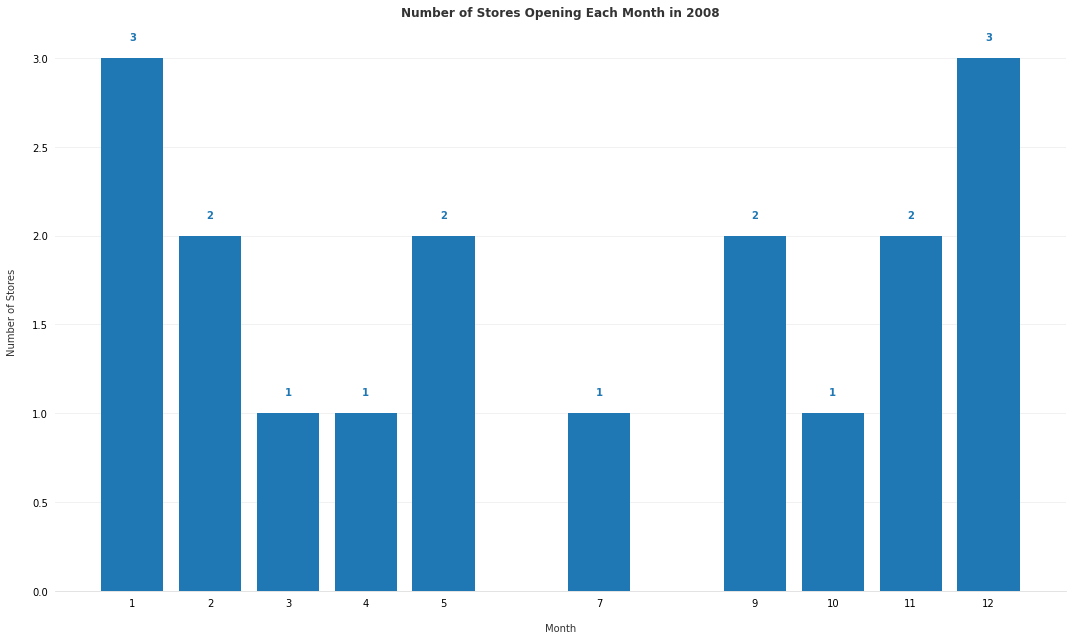

In [31]:
plt.rcParams['figure.figsize'] = (15, 9)

fig, ax = plt.subplots()

bars = ax.bar(
    x=df['month'],
    height=df['store_number'],
    tick_label=df["month"]
)

fig.tight_layout()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

bar_color = bars[0].get_facecolor()

for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.1,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

ax.set_title('Number of Stores Opening Each Month in 2008', pad=15, color='#333333', weight='bold')
ax.set_xlabel('Month', labelpad=15, color='#333333')
ax.set_ylabel('Number of Stores', labelpad=15, color='#333333')


fig.tight_layout()

- 9 stores first half
- 9 stores second half

## 2009

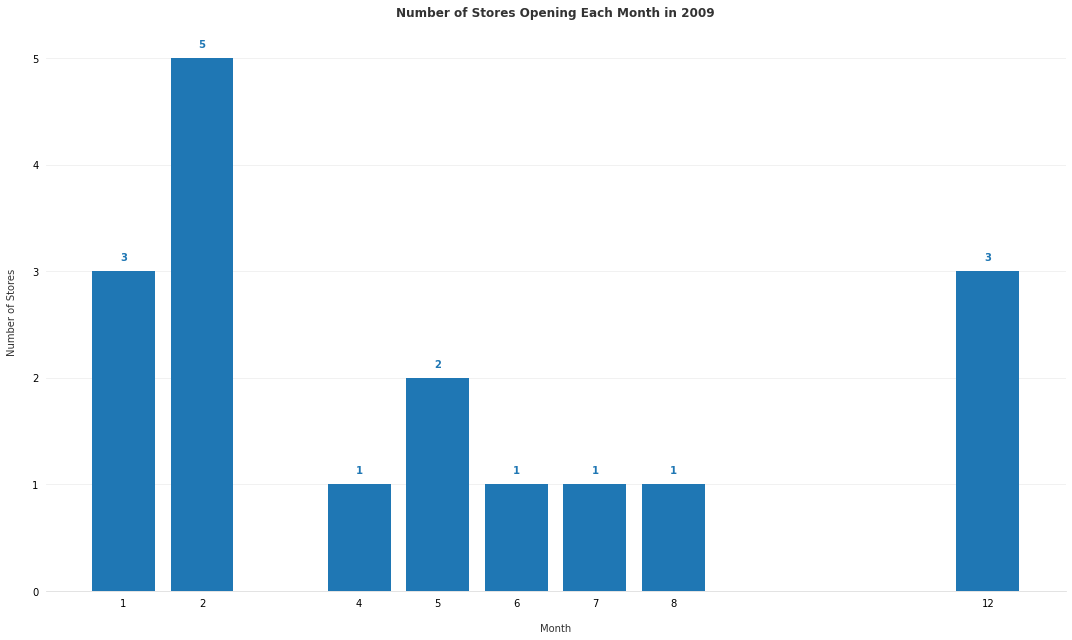

In [32]:
df_final_09 = df_final_copy[(df_final_copy.year==2009)].copy()
df=pd.DataFrame(df_final_09.groupby('month').count().reset_index(),columns=['month','store_number'])

plt.rcParams['figure.figsize'] = (15, 9)

fig, ax = plt.subplots()

bars = ax.bar(
    x=df['month'],
    height=df['store_number'],
    tick_label=df["month"]
)

fig.tight_layout()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

bar_color = bars[0].get_facecolor()

for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.1,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

ax.set_title('Number of Stores Opening Each Month in 2009', pad=15, color='#333333', weight='bold')
ax.set_xlabel('Month', labelpad=15, color='#333333')
ax.set_ylabel('Number of Stores', labelpad=15, color='#333333')


fig.tight_layout()

- 11 stores opening in first half
- 6 stores opening in second half 

## 2010

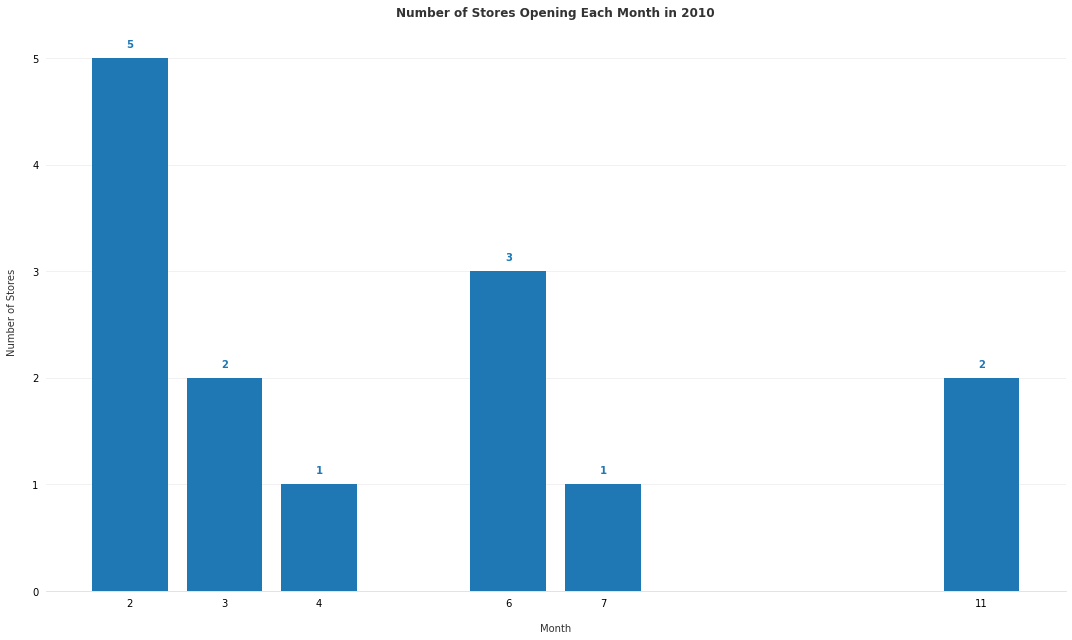

In [33]:
df_final_10 = df_final_copy[(df_final_copy.year==2010)].copy()
df=pd.DataFrame(df_final_10.groupby('month').count().reset_index(),columns=['month','store_number'])

plt.rcParams['figure.figsize'] = (15, 9)

fig, ax = plt.subplots()

bars = ax.bar(
    x=df['month'],
    height=df['store_number'],
    tick_label=df["month"]
)

fig.tight_layout()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

bar_color = bars[0].get_facecolor()

for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.1,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

ax.set_title('Number of Stores Opening Each Month in 2010', pad=15, color='#333333', weight='bold')
ax.set_xlabel('Month', labelpad=15, color='#333333')
ax.set_ylabel('Number of Stores', labelpad=15, color='#333333')


fig.tight_layout()

- 11 stores opening in first half
- 3 stores opening in second half

## 2011

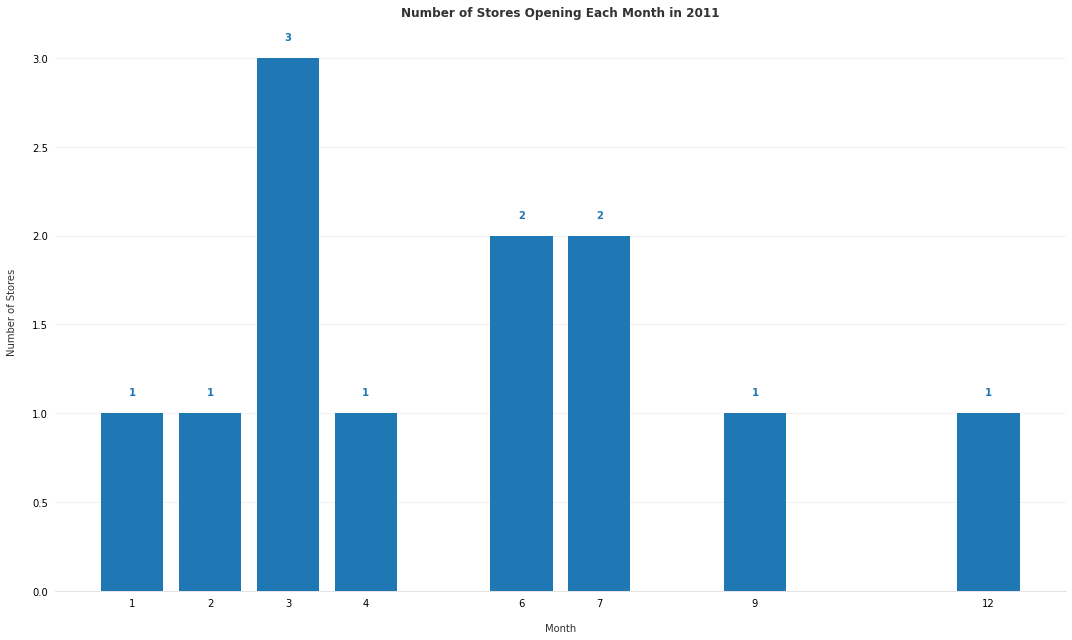

In [34]:
df_final_11 = df_final_copy[(df_final_copy.year==2011)].copy()
df=pd.DataFrame(df_final_11.groupby('month').count().reset_index(),columns=['month','store_number'])

plt.rcParams['figure.figsize'] = (15, 9)

fig, ax = plt.subplots()

bars = ax.bar(
    x=df['month'],
    height=df['store_number'],
    tick_label=df["month"]
)

fig.tight_layout()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

bar_color = bars[0].get_facecolor()

for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.1,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

ax.set_title('Number of Stores Opening Each Month in 2011', pad=15, color='#333333', weight='bold')
ax.set_xlabel('Month', labelpad=15, color='#333333')
ax.set_ylabel('Number of Stores', labelpad=15, color='#333333')


fig.tight_layout()

- 8 stores opening in first half
- 4 stores opening in second half

**After studying the spread of new stores opening, I found the years 2009-2010 to be the most compatible. In 2009 the majority stores had been built by June 2009 with only 6 opening in the latter half. The intervention time of 6 months would be the first half of 2010 in which 11 new stores had opened and after the intervention time, only 3 opening in the latter half.**

2008 to 2009 would have been tricky as there was an even spread of new stores opening in 2008 and there was more store information for the years 2009-2010 as compared to 2010 to 2011.

## Testing Treatment Group from 2009-2010

In this section, I am selecting stores that have had no new stores opening 6 months prior January 2010. The intervention period will be January 2010 to June 2010. No new stores opening after June 2010 till Dec 2010 should affect these stores either. 

- Exclude all stores that opened from July 2009 - Dec 2009
- Exclude all the stores that were affected by cannibilsation due to the new stores opening from Juy 2009-Dec2009
- Find the distance between currently existing stores with new stores opening in intervention phase (Jan-Jun 2010) 
- Select the treatment group as stores being within 10km of eachother
- Exclude if any of the stores falling within 10km proximity of eachother were affected by cannbilisation prior to the the intervention  period


In [35]:
#2009: 11 stores opened in the first half that is January 2009-June 2009 
#2009: 6 stores opened in the second half that is July 2009 - Dec 2009
#2010: 13 stores opened in the first half that is Jan 2010 - Jun 2010
#2010: 3 stores opened in second half that is July2010-Dec2010

#I want to test out intervention phase of 6 months in the first half of 2010


In [36]:
df_final_9 = df_final_copy[(df_final_copy.year<=2009)].copy()

### Exclude all stores that opened from July 2009 - Dec 2009

In [37]:
#Just 2009 stores 
df_second_half_2009= df_final_09[(df_final_09.month>6)].copy()

In [38]:
df_second_half_2009["store_number"].unique()

array([125, 227, 280, 229, 221], dtype=int64)

In [39]:
remove = [[125, 227, 280, 229, 221]]

In [40]:
#Dataframe of all existing store till June 2009
#.reset_index()
df_J2009 = df_final_9[~df_final_9.store_number.isin(remove)].copy()

### Exclude all the stores that were affected by cannibilsation due to the new stores opening from Juy 2009-Dec2009

In [41]:
df_J2009["CenterX_x"] = df_J2009["CenterX_x"].str.replace(',', '.').astype(float)
df_J2009["CenterY_x"] = df_J2009["CenterY_x"].str.replace(',', '.').astype(float)
df_second_half_2009["CenterY_x"] = df_second_half_2009["CenterY_x"].str.replace(',', '.').astype(float)
df_second_half_2009["CenterX_x"] = df_second_half_2009["CenterX_x"].str.replace(',', '.').astype(float)

In [42]:
z=[]
s=[]
c=[]
o=[]
for x, y in zip(df_J2009.CenterX_x, df_J2009.CenterY_x):
    coords_1=(x,y)
    l = []
    sn=[]
    ci=[]
    od=[]
    for a,b, store_num,cit,open_d in zip(df_second_half_2009.CenterX_x, df_second_half_2009.CenterY_x,df_second_half_2009.store_number, df_second_half_2009.city,df_second_half_2009.date_open):
        coords_2=(a,b)
        km = geopy.distance.geodesic(coords_1, coords_2).km
        l.append(km)
        snn= store_num
        sn.append(snn)
        city= cit
        ci.append(city) 
        odd=open_d
        od.append(odd)
    z.append(l)
    s.append(sn)
    c.append(ci)
    o.append(od)


In [43]:
df_J2009["distance"] = z
df_J2009["store_comp"] = s
df_J2009["city_comp"] = c
df_J2009["open_comp"] = o
df_J2009 = df_J2009.explode(['distance','store_comp', 'city_comp', "open_comp"])

In [44]:
df_J2009[(df_J2009.distance<11)]["store_number"].unique()

array([125, 227, 280, 229, 221, 200, 183, 231, 189, 161, 206], dtype=int64)

In [45]:
remove=[125, 227, 280, 229, 221, 200, 183, 152, 231, 189, 161, 206]

In [46]:
#Removed stores that had new stores opening nearby in the second half of 2009

df_J2009 = df_J2009[~df_J2009.store_number.isin(remove)].copy()

In [47]:
df_JJ2009 = df_J2009[['store_number', 'store_desc', "date_open", "city", "street", "CenterX_x", "CenterY_x"]].copy()

In [48]:
df_JJ2009 = df_JJ2009.drop_duplicates().copy()

In [49]:
df_JJ2009

,store_number,store_desc,date_open,city,street,CenterX_x,CenterY_x
75,219,Bp. III. Szentendrei út,2009-06-04,Budapest,Szentendrei út 251-253.,19.047845,47.580363
77,265,Nagykáta,2009-05-07,Nagykáta,Dózsa György Str.,19.739332,47.415664
78,245,Mezőtúr,2009-04-16,Mezőtúr,Földvári út 21,20.611891,47.002129
79,180,Zalaegerszeg Platán sor,2009-02-19,Zalaegerszeg,Platán sor 8/a.,16.834005,46.840350
80,209,Bp. XVI. János u.,2009-02-19,Budapest,János-Rákospalotai határ út,19.160772,47.534693
...,...,...,...,...,...,...,...
187,128,Mór,2004-11-18,Mór,Fő 81.,18.189333,47.375802
188,131,Kisvárda,2004-11-18,Kisvárda,Attila 2/a,22.075787,48.210395
189,133,Békéscsaba,2004-11-18,Békéscsaba,Corvin 29-33.,21.106280,46.670994
190,141,Barcs,2004-11-18,Barcs,Erkel F. 2.,17.466666,45.962336


## Find the distance between currently existing stores with new stores opening in intervention phase (Jan-Jun 2010)

In [50]:
#first half 2010 stores 
df_second_half_2010= df_final_10[(df_final_10.month>6)].copy()
df_first_half_2010= df_final_10[(df_final_10.month<=6)].copy()

In [51]:
df_first_half_2010["CenterY_x"] = df_first_half_2010["CenterY_x"].str.replace(',', '.').astype(float)
df_first_half_2010["CenterX_x"] = df_first_half_2010["CenterX_x"].str.replace(',', '.').astype(float)

#### Stores that opening in first half of 2010

In [52]:
df_first_half_2010

,store_number,store_desc,date_open,city,street,CenterX_x,CenterY_x,year,month
59,282,Bp. XXIII. Haraszti út,2010-06-17,Budapest,Haraszti út 34-36,19.109203,47.385956,2010,6
60,242,Törökszentmiklós,2010-06-03,Törökszentmiklós,Kossuth Lajos u. 102-110,20.416997,47.180434,2010,6
61,272,Enying,2010-06-03,Enying,Rákoczi Ferenc utca,18.248686,46.925446,2010,6
62,281,Tiszaújváros,2010-04-15,Tiszaújváros,Lévay J. u. 118,21.027904,47.937082,2010,4
63,249,Mezőkovácsháza,2010-03-11,Mezőkovácsháza,Árpád út 135-141.,20.918450,46.405926,2010,3
64,211,Siófok,2010-03-04,Siófok,Zamárdi út 1-2.,18.028263,46.900119,2010,3
65,202,Dunakeszi,2010-02-11,Dunakeszi,Berek út 2.,19.123452,47.623120,2010,2
66,233,Sátoraljaújhely,2010-02-11,Sátoraljaújhely,Esze Tamás,21.654853,48.387995,2010,2
67,287,Bp. XXI. Ady Endre u.,2010-02-11,Budapest,Ady Endre utca,19.075161,47.435176,2010,2
68,255,Bp. XVI. Újszász u.,2010-02-04,Budapest,Újszász utca 47/B,19.200844,47.505647,2010,2


In [53]:
z=[]
s=[]
c=[]
o=[]
for x, y in zip(df_JJ2009.CenterX_x, df_JJ2009.CenterY_x):
    coords_1=(x,y)
    l = []
    sn=[]
    ci=[]
    od=[]
    for a,b, store_num,cit,open_d in zip(df_first_half_2010.CenterX_x, df_first_half_2010.CenterY_x,df_first_half_2010.store_number, df_first_half_2010.city,df_first_half_2010.date_open):
        coords_2=(a,b)
        km = geopy.distance.geodesic(coords_1, coords_2).km
        l.append(km)
        snn= store_num
        sn.append(snn)
        city= cit
        ci.append(city) 
        odd=open_d
        od.append(odd)
    z.append(l)
    s.append(sn)
    c.append(ci)
    o.append(od)


In [54]:
df_JJ2009["distance"] = z
df_JJ2009["store_comp"] = s
df_JJ2009["city_comp"] = c
df_JJ2009["open_comp"] = o
df_JJ2009 = df_JJ2009.explode(['distance','store_comp', 'city_comp', "open_comp"])

## Select the treatment group as stores being within 10km of eachother


In [55]:
treated = df_JJ2009[(df_JJ2009.distance<11)].copy()  #12 minutes driving distance
treated["store_number"].unique()

array([219, 209, 205, 217, 235, 195, 226, 232, 210, 165, 167, 181, 160,
       175, 158, 109, 129, 136, 114], dtype=int64)

In [56]:
treat = treated[['store_number', 'store_desc', "date_open", "city", "street", "CenterX_x", "CenterY_x"]].copy()
treat = treat.drop_duplicates().copy()

#### All stores within 10km 

In [57]:
df_JJ2009[(df_JJ2009.distance<11)].sort_values("distance")

,store_number,store_desc,date_open,city,street,CenterX_x,CenterY_x,distance,store_comp,city_comp,open_comp
99,195,Bp. IX. Határ-Gubacsi út,2008-03-06,Budapest,Határ-Gubacsi,19.096528,47.444772,2.57175,287,Budapest,2010-02-11
183,114,Dunaharaszti,2004-11-18,Dunaharaszti,Némedi 102/a,19.118810,47.346744,4.260734,282,Budapest,2010-06-17
142,158,Bp. IV. Megyeri út,2005-12-15,Budapest,Megyeri út 53.,19.097378,47.588350,4.659987,202,Dunakeszi,2010-02-11
97,235,Bp. IX. Lobogó u.,2008-05-08,Budapest,Lobogó u. 12.,19.114643,47.461848,5.194051,287,Budapest,2010-02-11
80,209,Bp. XVI. János u.,2009-02-19,Budapest,János-Rákospalotai határ út,19.160772,47.534693,5.385979,255,Budapest,2010-02-04
106,232,Bp. X. Üllői-Ceglédi út,2007-12-13,Budapest,Üllői-Ceglédi,19.109760,47.473058,5.528094,287,Budapest,2010-02-11
114,165,Bp. X. Maglódi út,2007-08-02,Budapest,Maglódi út 17,19.153337,47.486543,5.629563,255,Budapest,2010-02-04
89,205,Bp. XV. Régi Fóti út,2008-12-04,Budapest,Régi Fóti út,19.132757,47.566967,5.997038,202,Dunakeszi,2010-02-11
124,181,Bp. X. Sibrik Miklós út,2006-12-21,Budapest,Gergely - Sibrik u.,19.155863,47.469836,6.243308,255,Budapest,2010-02-04
99,195,Bp. IX. Határ-Gubacsi út,2008-03-06,Budapest,Határ-Gubacsi,19.096528,47.444772,6.346079,282,Budapest,2010-06-17


## Exclude if any of the stores falling within 10km proximity of eachother were affected by cannbilisation prior to the the intervention period

In [58]:
df_second_half_2010["CenterY_x"] = df_second_half_2010["CenterY_x"].str.replace(',', '.').astype(float)
df_second_half_2010["CenterX_x"] = df_second_half_2010["CenterX_x"].str.replace(',', '.').astype(float)

In [59]:
z=[]
s=[]
c=[]
o=[]
for x, y in zip(treat.CenterX_x, treat.CenterY_x):
    coords_1=(x,y)
    l = []
    sn=[]
    ci=[]
    od=[]
    for a,b, store_num,cit,open_d in zip(df_second_half_2010.CenterX_x, df_second_half_2010.CenterY_x,df_second_half_2010.store_number, df_second_half_2010.city,df_second_half_2010.date_open):
        coords_2=(a,b)
        km = geopy.distance.geodesic(coords_1, coords_2).km
        l.append(km)
        snn= store_num
        sn.append(snn)
        city= cit
        ci.append(city) 
        odd=open_d
        od.append(odd)
    z.append(l)
    s.append(sn)
    c.append(ci)
    o.append(od)


In [60]:
treat["distance"] = z
treat["store_comp"] = s
treat["city_comp"] = c
treat["open_comp"] = o
treat = treat.explode(['distance','store_comp', 'city_comp', "open_comp"])

In [61]:
 treat[(treat.distance<11)]

,store_number,store_desc,date_open,city,street,CenterX_x,CenterY_x,distance,store_comp,city_comp,open_comp


None of the treated stores are later affected. 